In [53]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [54]:
# Generate data
def generate_data(n, mod=100, batchSize=16):
    A = np.random.rand(n) * 100
    B = np.random.rand(n) * 100
    y = A + B
    data = np.column_stack((A, B))
    labels = y.reshape(y.shape[0], 1)
    # Convert data into tensors
    dataT = torch.tensor(data).float()
    labelsT = torch.tensor(labels).float()

    # train test splits
    train_data, test_data_temp, train_labels, test_labels_temp = train_test_split(
        dataT, labelsT, train_size=0.8
    )
    test_data, dev_data, test_labels, dev_labels = train_test_split(
        test_data_temp, test_labels_temp, train_size=0.5
    )

    # Pytorch datasets
    train_dataT = TensorDataset(train_data, train_labels)
    dev_dataT = TensorDataset(dev_data, dev_labels)
    test_dataT = TensorDataset(test_data, test_labels)

    # Dataloader objects
    train_loader = DataLoader(
        train_dataT,
        batch_size=batchSize,
        shuffle=True,
        drop_last=True,
        generator=torch.Generator(device),
    )
    dev_loader = DataLoader(
        dev_dataT,
        batch_size=dev_dataT.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    test_loader = DataLoader(
        test_dataT,
        batch_size=test_dataT.tensors[0].shape[0],
        generator=torch.Generator(device),
    )
    return train_loader, dev_loader, test_loader

In [55]:
# Function to create the class
def createTheModel():
    class Sum2NumbersClass(nn.Module):
        def __init__(self):
            super().__init__()

            # Input
            self.input = nn.Linear(2, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 64)
            self.hidden2 = nn.Linear(64, 1)
            # Output Layers
            self.output = nn.Linear(1, 1)

        def forward(self, x):
            # Input
            x = F.relu(self.input(x))

            # Hidden Layers
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            # Output Layers
            return self.output(x)

    net = Sum2NumbersClass()

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    return net, lossFun, optimizer

In [56]:
# Test the model
net, lossFun, optimizer = createTheModel()
tempData = torch.tensor(100 * np.random.randn(100, 2)).float()
print(net(tempData))

tensor([[-1.0958],
        [-1.1845],
        [-0.8825],
        [-1.2993],
        [-1.5797],
        [-1.0427],
        [-1.0903],
        [-0.8825],
        [-0.8825],
        [-0.8825],
        [-0.9365],
        [-1.0350],
        [-0.9362],
        [-0.8956],
        [-0.8825],
        [-0.8825],
        [-0.8825],
        [-0.8825],
        [-1.1033],
        [-0.8825],
        [-0.9811],
        [-1.0498],
        [-0.8825],
        [-1.0668],
        [-0.8825],
        [-1.0996],
        [-1.1583],
        [-0.9550],
        [-1.6959],
        [-0.8825],
        [-0.8825],
        [-1.0436],
        [-0.8825],
        [-1.2618],
        [-0.8825],
        [-1.0125],
        [-0.8825],
        [-0.8825],
        [-0.8825],
        [-1.0078],
        [-1.1941],
        [-0.8825],
        [-1.0865],
        [-1.2499],
        [-1.1689],
        [-1.2159],
        [-0.8825],
        [-1.1416],
        [-1.1210],
        [-0.9196],
        [-1.0330],
        [-1.0373],
        [-0.

In [ ]:
# epochs
nEpochs = 30


def trainTheModel():
    # Model Instance
    net, lossFun, optimizer = createTheModel()

    # Initialize variables
    trainAcc = []
    devAcc = []
    losses = np.zeros(nEpochs)

    # The loop
    for epoch in range(nEpochs):
        # Model training mode
        net.train()

        # Batch loss and accuracy initialization
        batchLoss = []
        batchAcc = []

        # The batch loop
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append((100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu())

        # Batch loop end

        # Train Acc
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Dev accuracy
        net.eval()
        X, y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
        devAcc.append((100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu())

    # The Loop End

    return trainAcc, devAcc, losses

In [66]:
# Train the model
train_loader, dev_loader, test_loader = generate_data(n=500)
nEpochs = 100
trainAcc, devAcc, losses = trainTheModel()
print(trainAcc)

[1.5, 12.0, 26.5, 49.5, 84.0, 93.0, 95.25, 96.5, 96.25, 97.0, 98.25, 98.75, 98.25, 99.0, 99.25, 99.25, 99.5, 99.5, 99.5, 99.25, 99.5, 100.0, 99.5, 99.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


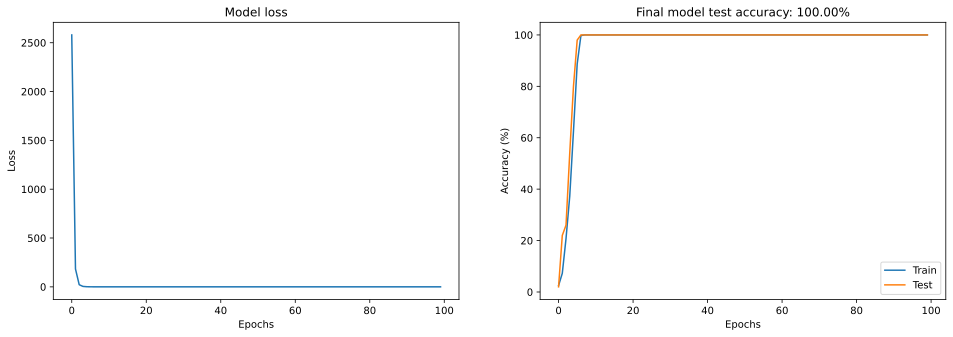

In [63]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(devAcc, label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model test accuracy: {devAcc[-1]:.2f}%")
ax[1].legend()

plt.show()